In [1]:
# PyTorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# For data preprocess
import numpy as np
import csv
import os

# For plotting
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

# 使用指定的种子，使网络初始化的参数固定。
myseed = 42069
# 强制CUDNN使用确定性的算法，这意味着当你在 GPU 上运行相同的输入数据和相同的模型时，每次的结果都是相同的。
torch.backends.cudnn.deterministic = True
# uDNN 有一个自动优化机制，它会根据输入数据的大小和配置选择最优的算法来加速计算。
# 当 benchmark 设置为 True 时，CuDNN 会运行一系列的算法并选择最快的那个。
# 这个过程会导致运行时的变动，特别是当输入数据的形状变化时，每次选择的算法可能不同，从而导致结果的不一致。
torch.backends.cudnn.benchmark = False
np.random.seed(myseed)
torch.manual_seed(myseed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(myseed)

# 工具函数

In [2]:
def get_device():
    ''' Get device (if GPU is available, use GPU) '''
    # 检查当前环境中是否有可用的 GPU
    # 如果有 GPU 则返回 'cuda'，否则返回 'cpu'
    return 'cuda' if torch.cuda.is_available() else 'cpu'


def plot_learning_curve(loss_record, title=''):
    ''' Plot learning curve of your DNN (train & dev loss) '''
    # 计算训练集的总步数（即训练过程中记录的损失值的数量）
    total_steps = len(loss_record['train'])
    # 创建一个范围对象，表示训练步骤的范围
    x_1 = range(total_steps)
    # 根据训练集和验证集损失记录的长度比率，计算出验证集的 x 轴刻度
    x_2 = x_1[::len(loss_record['train']) // len(loss_record['dev'])]
    # 设置图表的大小为 6x4 英寸
    figure(figsize=(6, 4))
    # 绘制训练集的损失曲线，颜色为红色
    plt.plot(x_1, loss_record['train'], c='tab:red', label='train')
    # 绘制验证集的损失曲线，颜色为青色
    plt.plot(x_2, loss_record['dev'], c='tab:cyan', label='dev')
    # 设置 y 轴的范围为 [0.0, 5.0]
    plt.ylim(0.0, 5.)
    # 设置 x 轴标签为 "Training steps"
    plt.xlabel('Training steps')
    # 设置 y 轴标签为 "MSE loss"
    plt.ylabel('MSE loss')
    # 设置图表标题，可以指定模型的名称或其他说明
    plt.title('Learning curve of {}'.format(title))
    # 显示图例（即训练集和验证集的标签）
    plt.legend()
    # 显示绘制好的图表
    plt.show()


def plot_pred(dv_set, model, device, lim=35., preds=None, targets=None):
    ''' Plot prediction of your DNN '''
    # 如果没有提供预测值和目标值，则需要进行推理来获取它们
    if preds is None or targets is None:
        # 将模型设置为评估模式，以禁用 dropout 等影响推理的操作
        model.eval()
        # 初始化空列表，用于存储预测值和实际目标值
        preds, targets = [], []
        # 遍历验证集或测试集的数据
        for x, y in dv_set:
            # 将输入数据 x 和目标值 y 移动到指定的设备（CPU 或 GPU）
            x, y = x.to(device), y.to(device)
            # 在不计算梯度的上下文中进行推理
            with torch.no_grad():
                # 获取模型的预测值
                pred = model(x)
                # 将预测值添加到 preds 列表中，并将其移回 CPU
                preds.append(pred.detach().cpu())
                # 将实际目标值添加到 targets 列表中，并将其移回 CPU
                targets.append(y.detach().cpu())
        # 将所有批次的预测值和目标值连接起来，并转换为 NumPy 数组
        preds = torch.cat(preds, dim=0).numpy()
        targets = torch.cat(targets, dim=0).numpy()
    # 设置图表的大小为 5x5 英寸
    figure(figsize=(5, 5))
    # 绘制预测值和实际目标值的散点图，点的颜色为红色，透明度为 0.5
    plt.scatter(targets, preds, c='r', alpha=0.5)
    # 绘制理想的预测线（即 y = x），颜色为蓝色
    plt.plot([-0.2, lim], [-0.2, lim], c='b')
    # 设置 x 轴的范围为 [-0.2, lim]
    plt.xlim(-0.2, lim)
    # 设置 y 轴的范围为 [-0.2, lim]
    plt.ylim(-0.2, lim)
    # 设置 x 轴标签为 "ground truth value"
    plt.xlabel('ground truth value')
    # 设置 y 轴标签为 "predicted value"
    plt.ylabel('predicted value')
    # 设置图表标题为 "Ground Truth v.s. Prediction"
    plt.title('Ground Truth v.s. Prediction')
    # 显示绘制好的图表
    plt.show()


# 数据处理

In [3]:
import csv
import numpy as np
import torch
from torch.utils.data import Dataset

class COVID19Dataset(Dataset):
    ''' Dataset for loading and preprocessing the COVID19 dataset '''

    def __init__(self, path, mode='train', target_only=False):
        ''' 初始化方法
        Args:
            path (str): 数据文件的路径
            mode (str): 数据集模式，可以是 'train', 'dev' 或 'test'
            target_only (bool): 是否只使用目标变量
        '''
        self.mode = mode

        # 读取数据到 numpy 数组中
        with open(path, 'r') as fp:
            data = list(csv.reader(fp))
            # 读取文件中的数据，将其转换为 numpy 数组
            # 先选中第二行到最后一行，转化为numpy
            # 然后选择所有行，和第二列到最后一列的数据转化为float
            data = np.array(data[1:])[:, 1:].astype(float)
        
        if not target_only:
            # 如果不是仅使用目标变量，则选择所有特征（假设有 93 个特征）
            feats = list(range(93))
        else:
            # TODO: 使用 40 个州和 2 个测试阳性特征（索引 = 57 和 75）
            # 如果只使用目标变量，则需要在这里完成
            pass

        if mode == 'test':
            # 如果模式是测试，数据的形状为 893 x 93
            # 选择所有特征
            data = data[:, feats]
            # 将数据转换为 PyTorch 浮点张量
            self.data = torch.FloatTensor(data)
        else:
            # 如果模式是训练或验证
            # 目标是数据的最后一列
            target = data[:, -1]
            # 选择所有特征
            data = data[:, feats]
            
            # 将训练数据拆分为训练集和验证集
            if mode == 'train':
                # 训练集：选择所有的样本，但跳过每第 10 个样本
                indices = [i for i in range(len(data)) if i % 10 != 0]
            elif mode == 'dev':
                # 验证集：选择每第 10 个样本
                indices = [i for i in range(len(data)) if i % 10 == 0]
            
            # 将数据和目标转换为 PyTorch 浮点张量
            self.data = torch.FloatTensor(data[indices])
            self.target = torch.FloatTensor(target[indices])

        # 对特征进行归一化
        self.data[:, 40:] = \
            (self.data[:, 40:] - self.data[:, 40:].mean(dim=0, keepdim=True)) \
            / self.data[:, 40:].std(dim=0, keepdim=True)

        # 保存数据的维度（特征数量）
        self.dim = self.data.shape[1]

        # 打印数据集的基本信息
        print('Finished reading the {} set of COVID19 Dataset ({} samples found, each dim = {})'
              .format(mode, len(self.data), self.dim))

    def __getitem__(self, index):
        ''' 返回指定索引的样本
        Args:
            index (int): 数据的索引
        Returns:
            tuple: 对于训练和验证模式，返回数据和目标；对于测试模式，仅返回数据
        '''
        if self.mode in ['train', 'dev']:
            # 对于训练和验证模式，返回数据和目标
            return self.data[index], self.target[index]
        else:
            # 对于测试模式，仅返回数据
            return self.data[index]

    def __len__(self):
        ''' 返回数据集的大小
        Returns:
            int: 数据集中样本的数量
        '''
        return len(self.data)


# DataLoader

In [4]:
def prep_dataloader(path, mode, batch_size, n_jobs=0, target_only=False):
    ''' Generates a dataset, then is put into a dataloader. '''
    dataset = COVID19Dataset(path, mode=mode, target_only=target_only)  # Construct dataset
    dataloader = DataLoader(
        dataset, batch_size,
        shuffle=(mode == 'train'), drop_last=False,
        num_workers=n_jobs, pin_memory=True)                            # Construct dataloader
    return dataloader

# 模型

In [5]:
# swish激活函数
class Swish(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)

class NeuralNet(nn.Module):
    ''' A simple fully-connected deep neural network '''
    def __init__(self, input_dim):
        super(NeuralNet, self).__init__()
        
        # 使用swish激活函数
        self.swish1 = Swish()

        # Define your neural network here
        # TODO: How to modify this model to achieve better performance?
        self.net = nn.Sequential(
            nn.Linear(input_dim, config['hidden_dim_01']),
            # nn.BatchNorm1d(config['hidden_dim_01']),
            Swish(),
            
            nn.Linear(config['hidden_dim_01'], config['hidden_dim_02']),
            # nn.BatchNorm1d(config['hidden_dim_02']),
            Swish(),
            
            nn.Linear(config['hidden_dim_02'], config['hidden_dim_03']),
            # nn.BatchNorm1d(config['hidden_dim_03']),
            Swish(),
            
            nn.Linear(config['hidden_dim_03'], 1)
        )

        # Mean squared error loss
        self.criterion = nn.MSELoss(reduction='mean')
        

    def forward(self, x):
        ''' Given input of size (batch_size x input_dim), compute output of the network '''
        # print(x.shape)
        return self.net(x).squeeze(1)

    def cal_loss(self, pred, target):
        ''' Calculate loss '''
        # TODO: you may implement L1/L2 regularization here
        return self.criterion(pred, target)

# 训练

In [6]:
def train(tr_set, dv_set, model, config, device):
    ''' DNN training '''
    
    # 从配置字典中获取训练轮次
    n_epochs = config['n_epochs']  # Maximum number of epochs

    # 用于动态获取 PyTorch 的优化器类（例如 SGD 或 Adam），其名称从配置字典 config 中的 optimizer 键获取。
    optimizer = getattr(torch.optim, config['optimizer'])(
        model.parameters(), **config['optim_hparas'])

    min_mse = 1000.
    loss_record = {'train': [], 'dev': []}      # for recording training loss
    # 初始化早停计数器：early_stop_cnt 用于记录验证损失在多少个周期内没有改善。若达到预设值，则停止训练以避免过拟合。
    early_stop_cnt = 0
    epoch = 0
    while epoch < n_epochs:
        model.train()                           # set model to training mode
        for x, y in tr_set:                     # iterate through the dataloader
            optimizer.zero_grad()               # set gradient to zero
            x, y = x.to(device), y.to(device)   # move data to device (cpu/cuda)
            pred = model(x)                     # forward pass (compute output)
            mse_loss = model.cal_loss(pred, y)  # compute loss
            mse_loss.backward()                 # compute gradient (backpropagation)
            optimizer.step()                    # update model with optimizer
            loss_record['train'].append(mse_loss.detach().cpu().item())

        # After each epoch, test your model on the validation (development) set.
        # 验证，dev函数在下面
        dev_mse = dev(dv_set, model, device)
        if dev_mse < min_mse:
            # Save model if your model improved
            min_mse = dev_mse
            print('Saving model (epoch = {:4d}, loss = {:.4f})'
                .format(epoch + 1, min_mse))
            torch.save(model.state_dict(), config['save_path'])  # Save model to specified path
            early_stop_cnt = 0
        else:
            early_stop_cnt += 1

        epoch += 1
        loss_record['dev'].append(dev_mse)
        if early_stop_cnt > config['early_stop']:
            # Stop training if your model stops improving for "config['early_stop']" epochs.
            break

    print('Finished training after {} epochs'.format(epoch))
    return min_mse, loss_record

# 验证函数

In [7]:
def dev(dv_set, model, device):
    model.eval()                                # set model to evalutation mode
    total_loss = 0
    for x, y in dv_set:                         # iterate through the dataloader
        x, y = x.to(device), y.to(device)       # move data to device (cpu/cuda)
        with torch.no_grad():                   # disable gradient calculation
            pred = model(x)                     # forward pass (compute output)
            mse_loss = model.cal_loss(pred, y)  # compute loss
        total_loss += mse_loss.detach().cpu().item() * len(x)  # accumulate loss
    total_loss = total_loss / len(dv_set.dataset)              # compute averaged loss

    return total_loss

# 测试

In [8]:
def test(tt_set, model, device):
    model.eval()                                # set model to evalutation mode
    preds = []
    for x in tt_set:                            # iterate through the dataloader
        x = x.to(device)                        # move data to device (cpu/cuda)
        with torch.no_grad():                   # disable gradient calculation
            pred = model(x)                     # forward pass (compute output)
            preds.append(pred.detach().cpu())   # collect prediction
    preds = torch.cat(preds, dim=0).numpy()     # concatenate all predictions and convert to a numpy array
    return preds

# 配置参数

In [40]:
device = get_device()                 # get the current available device ('cpu' or 'cuda')
os.makedirs('models', exist_ok=True)  # The trained model will be saved to ./models/
target_only = False                   # TODO: Using 40 states & 2 tested_positive features

# TODO: How to tune these hyper-parameters to improve your model's performance?
config = {
    'n_epochs': 3000,                # maximum number of epochs
    'batch_size': 270,               # mini-batch size for dataloader
    'optimizer': 'SGD',              # optimization algorithm (optimizer in torch.optim)
    'optim_hparas': {                # hyper-parameters for the optimizer (depends on which optimizer you are using)
        'lr': 0.001,                 # learning rate of SGD
        'momentum': 0.9              # momentum for SGD
    },
    'early_stop': 200,               # early stopping epochs (the number epochs since your model's last improvement)
    'save_path': 'models/model.pth',  # your model will be saved here
    
    'hidden_dim_01': 64,
    'hidden_dim_02': 32,
    'hidden_dim_03': 16,
}

# 加载数据

In [11]:
tr_path = '../../../2021ML作业数据/HW1/ml2021spring-hw1/covid.train.csv'
tt_path = '../../../2021ML作业数据/HW1/ml2021spring-hw1/covid.test.csv'
tr_set = prep_dataloader(tr_path, 'train', config['batch_size'], target_only=target_only)
dv_set = prep_dataloader(tr_path, 'dev', config['batch_size'], target_only=target_only)
tt_set = prep_dataloader(tt_path, 'test', config['batch_size'], target_only=target_only)

Finished reading the train set of COVID19 Dataset (2430 samples found, each dim = 93)
Finished reading the dev set of COVID19 Dataset (270 samples found, each dim = 93)
Finished reading the test set of COVID19 Dataset (893 samples found, each dim = 93)


# 开始训练

In [41]:
model = NeuralNet(tr_set.dataset.dim).to(device)  # Construct model and move to device
model_loss, model_loss_record = train(tr_set, dv_set, model, config, device)

Saving model (epoch =    1, loss = 282.3711)
Saving model (epoch =    2, loss = 213.8787)
Saving model (epoch =    3, loss = 75.2899)
Saving model (epoch =    4, loss = 39.1253)
Saving model (epoch =    5, loss = 9.7333)
Saving model (epoch =    6, loss = 8.5340)
Saving model (epoch =    7, loss = 6.1460)
Saving model (epoch =    8, loss = 4.3852)
Saving model (epoch =    9, loss = 3.1758)
Saving model (epoch =   10, loss = 2.5260)
Saving model (epoch =   11, loss = 2.0140)
Saving model (epoch =   12, loss = 1.6941)
Saving model (epoch =   13, loss = 1.5358)
Saving model (epoch =   14, loss = 1.4913)
Saving model (epoch =   15, loss = 1.3671)
Saving model (epoch =   16, loss = 1.3249)
Saving model (epoch =   17, loss = 1.3065)
Saving model (epoch =   18, loss = 1.2613)
Saving model (epoch =   20, loss = 1.2260)
Saving model (epoch =   21, loss = 1.2147)
Saving model (epoch =   22, loss = 1.1923)
Saving model (epoch =   24, loss = 1.1830)
Saving model (epoch =   25, loss = 1.1521)
Savin

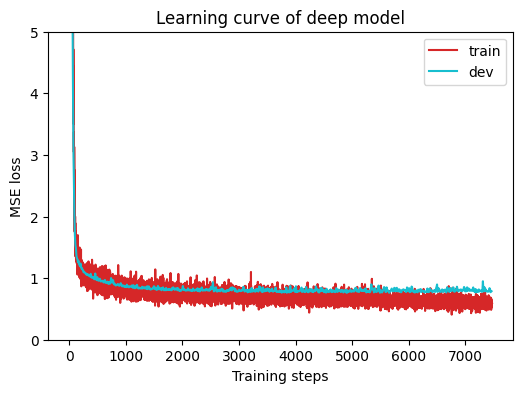

In [42]:
plot_learning_curve(model_loss_record, title='deep model')

# 预测

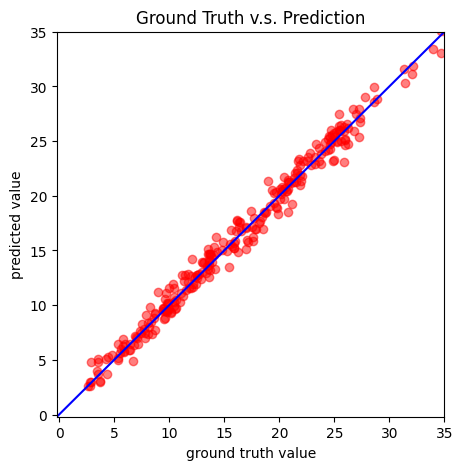

In [43]:
del model
model = NeuralNet(tr_set.dataset.dim).to(device)
ckpt = torch.load(config['save_path'], map_location='cpu')  # Load your best model
model.load_state_dict(ckpt)
plot_pred(dv_set, model, device)  # Show prediction on the validation set